# Compare the wavefunctions to ARC

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from numerov.radial.radial_matrix_element import calc_radial_matrix_element_from_w_z
from numerov.rydberg import RydbergState
from numerov.units import ureg

logging.basicConfig(level=logging.INFO, format="%(levelname)s %(filename)s: %(message)s")
logging.getLogger("numerov").setLevel(logging.WARNING)

In [2]:
n = 120
dn, dl, dj, dm = (3, 1, 0, 0)

qn1 = (n, n - 1, n - 0.5, n - 0.5)
qn2 = (qn1[0] + dn, qn1[1] + dl, qn1[2] + dj, qn1[3] + dm)
qns = [qn1, qn2]

dz = 1e-2

In [3]:
results = {
    "Numerov": [],
    "ARC default": [],
    "ARC fixed": [],
}

In [4]:
atoms = []
for qn in qns:
    atom = RydbergState("Rb", n=qn[0], l=qn[1], j=qn[2])
    atom.create_grid(dz=dz)
    atom.integrate_wavefunction()
    results["Numerov"].append(
        {
            "x": atom.grid.xlist,
            "z": atom.grid.zlist,
            "u": atom.wavefunction.ulist,
            "w": atom.wavefunction.wlist,
            "z_cutoff": atom.grid.zmin,
        }
    )
    atoms.append(atom)

In [5]:
import arc
from arc_functions import arc_radialWavefunction

atom = arc.Rubidium87()

for use_fixed_arc in [False, True]:
    key = "ARC fixed" if use_fixed_arc else "ARC default"
    for qn in qns:
        r, psi_r = arc_radialWavefunction(atom, *qn[:3], use_fixed_arc=use_fixed_arc)
        arg_rmin = np.argwhere(psi_r != 0).flatten()[0]
        results[key].append(
            {
                "x": np.array(r),
                "z": np.sqrt(r),
                "u": np.array(psi_r),
                "w": np.array(psi_r) / np.power(r, 1 / 4),
                "z_cutoff": np.sqrt(r[arg_rmin]),
            }
        )

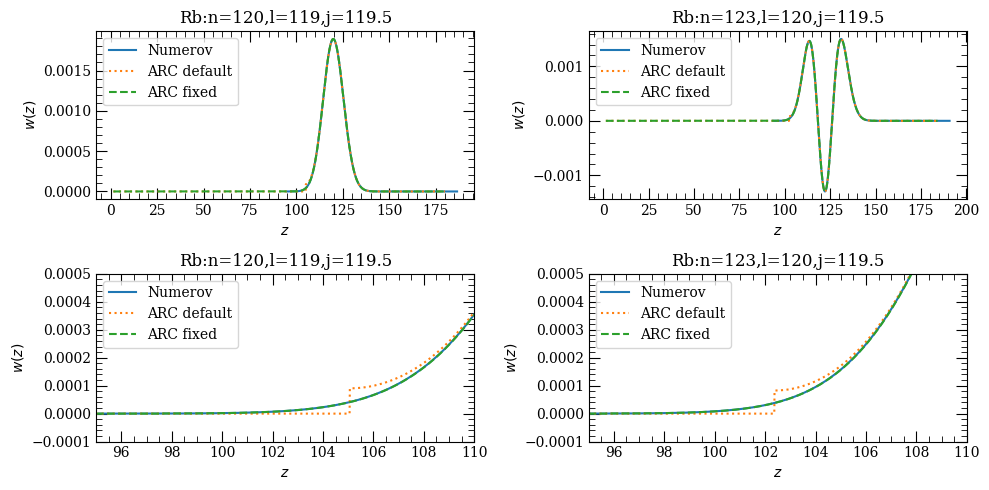

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

for j, row in enumerate(axs):
    for i, ax in enumerate(row):
        for k, r_list in results.items():
            r = r_list[i]
            ls = {"Numerov": "-", "ARC default": ":", "ARC fixed": "--"}.get(k, k)
            ax.plot(r["z"], r["w"], ls=ls, label=f"{k}")

        ax.set_xlabel(r"$z$")
        ax.set_ylabel(r"$w(z)$")
        ax.legend()
        ax.set_title(f"{atoms[i].species}:n={atoms[i].n},l={atoms[i].l},j={atoms[i].j}")

        if j == 1:
            ax.set_xlim(95, 110)
            ax.set_ylim(-1e-4, 5e-4)

fig.tight_layout()
plt.show()

In [7]:
# the small difference of the wavefunctions explains the difference in the radial matrix element of circular states
# (see also the benchmark_circular_matrixelements.ipynb notebook)
to_mum = ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

for key in results.keys():
    key1 = key2 = key
    i1, i2 = 0, 1
    overlap = calc_radial_matrix_element_from_w_z(
        results[key1][i1]["z"], results[key1][i1]["w"], results[key2][i2]["z"], results[key2][i2]["w"], r_power=1
    )
    print(rf"matrix element <{key1}_{i1}|{key2}_{i2}> = {overlap * to_mum} $\mu m$")

matrix element <Numerov_0|Numerov_1> = 0.006611390561710852 $\mu m$
matrix element <ARC default_0|ARC default_1> = 0.007833201800644469 $\mu m$
matrix element <ARC fixed_0|ARC fixed_1> = 0.006614557048661213 $\mu m$
